### PINO/FNO Architecture 

This model was heavily influenced by Bilal Thonnam Thodi on their work [1].

[1] B. T. Thodi, S. V. R. Ambadipudi, and S. E. Jabari. Fourier neural operator for learning
solutions to macroscopic traffic flow models: Application to the forward and inverse
problems, 2023 - code https://github.com/bilzinet/pifno



#-----------------------------------------------------------------------------------------

Copyright information from Bilal Thonnam Thodi

''MIT License

Copyright (c) 2022 Bilal Thonnam Thodi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.''

#-----------------------------------------------------------------------------------------

## Approximating a Solution to the 1D Heat Equation for c = 7 using the FNO architecture

Consider the 1D heat equation

\begin{equation}
  u_t = c u_{xx} \quad \textrm{ for } x \in \left( 0, 1 \right), t \in \left( 0, T \right), \text{ such that } c>0
\end{equation}

subject to an initial condition

\begin{equation}
  u \left( x, t = 0 \right) = \sin \left( 2 \pi x \right) + 2 \sin \left( 5 \pi x \right),
\end{equation}

and homogeneous Dirichlet boundary conditions

\begin{equation}
  u \left( x = 0, t \right) = u \left( x = 1, t \right) = 0.
\end{equation}

Here, we use 33 train samples, 1 test samples both with grid resolution of 51  x  50.

In [23]:
# load packages
import sys
import numpy as np
import torch
import torch.nn as nn
import pickle as pkl
import torch.nn.functional as F
## added extra
import os
##
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(device)

# Fourier Neural Operator
#Fourier Neural Operator (Reference: https://arxiv.org/pdf/2010.08895.pdf)
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        """
        2D Fourier layer: FFT -> Linear Transform -> Inverse FFT  
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1 (floor rounds down)
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def forward(self, x):
        # Perform Fourier transform
        batchsize = x.shape[0]
        # Compute the real-valued 2D Fourier transform
        x_ft = torch.fft.rfft2(x, norm="ortho")
        # Multiply top Fourier modes with Fourier weights
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            torch.einsum('bixy,ioxy->boxy',x_ft[:, :, :self.modes1, :self.modes2],torch.view_as_complex(self.weights1))
            
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            torch.einsum('bixy,ioxy->boxy',x_ft[:, :, :self.modes1, :self.modes2],torch.view_as_complex(self.weights2))
        # Compute the inverse real-valued 2D Fourier transform
        x = torch.fft.irfft2(out_ft, norm="ortho")
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(SimpleBlock2d, self).__init__()
        """
        The overall network. It contains 4-8 Fourier layers.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4-8 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)
        self.w7 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        # FNO Layer 2
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        # FNO Layer 3
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        
        # FNO Layer 4
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        '''
        # FNO Layer 5
        x1 = self.conv3(x)
        x2 = self.w4(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        
        # FNO Layer 6
        x1 = self.conv3(x)
        x2 = self.w5(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        
        # FNO Layer 7
        x1 = self.conv3(x)
        x2 = self.w6(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        # FNO Layer 8
        x1 = self.conv3(x)
        x2 = self.w7(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        '''
        # Projection Q
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()
        """
        A wrapper function
        """
        self.conv1 = SimpleBlock2d(modes1, modes2,  width)

    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))
        return c
    
class DataLoss(object):
    def __init__(self, p=2):
        super(DataLoss, self).__init__()
        self.p = p

    def data_loss(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        return torch.mean(diff_norms/y_norms)
    
    def __call__(self, x, y):
        return self.data_loss(x, y)
    
# initiale weights
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    if type(m) == torch.nn.Conv1d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# random masking of boundary values
def rand_mask(x_test, mp=0):
    if mp==0:
        return x_test
    else:
        mk=int(mp*x_test.shape[1])
        mind=np.random.randint(0,x_test.shape[1],size=(x_test.shape[0],mk))
        for i in range(mind.shape[0]):
            x_test[...,0][i,mind[i,:]]=-1
            x_test[...,-1][i,mind[i,:]]=-1
        return x_test
    
#load data
def load_data(f_names_train, f_names_test, data_fold_train, data_fold_test, b_size, ntest_sc, ntest_max, train=True, normalize=True, **kwargs):
    
    # load test data
    x_test = []; y_test = []
    for f in f_names_test:
        with open(data_fold_test+f'{f}.pkl','rb') as f:
            data = pkl.load(f)
        x_test.append(data['X'][:ntest_sc])
        y_test.append(data['Y'][:ntest_sc])
    x_test = np.concatenate(x_test, axis=0).astype(np.float32)
    y_test = np.concatenate(y_test, axis=0).astype(np.float32)
    x_test = x_test[:ntest_max,:,:]
    y_test = y_test[:ntest_max,:,:]
    x_test[:,1:,1:-1] = -1
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)
    
    # grid size params
    s1 = x_test.shape[1]
    s2 = x_test.shape[2]
    ntest = x_test.shape[0]
    
    # load train data if required
    ntrain = 0
    if train:
        x_train = []; y_train = []
        for f in f_names_train:
            with open(data_fold_train+f'{f}.pkl','rb') as f:
                data = pkl.load(f)
            x_train.append(data['X'][:ntrain_sc])
            y_train.append(data['Y'][:ntrain_sc])
        x_train = np.concatenate(x_train, axis=0).astype(np.float32)
        y_train = np.concatenate(y_train, axis=0).astype(np.float32)
        x_train = x_train[:ntrain_max,:,:]
        y_train = y_train[:ntrain_max,:,:]
        x_train[:,1:,1:-1] = -1
        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train)    
        ntrain = x_train.shape[0]
    
    # concat location coordinates
    grids = []
    grids.append((np.linspace(1,600,s1)+np.linspace(0,600-1,s1))/2)  
    grids.append((np.linspace(20,1000,s2)+np.linspace(0,1000-20,s2))/2)  
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
    grid = grid.reshape(1,s1,s2,2)
    grid = torch.tensor(grid, dtype=torch.float)
    x_test = torch.cat([x_test.reshape(ntest,s1,s2,1), 
                        grid.repeat(ntest,1,1,1)], dim=3)
    
    # pytorch loader
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), 
        batch_size=b_size, shuffle=False)
    train_loader = None
    if train:
        x_train = torch.cat([x_train.reshape(ntrain,s1,s2,1), 
                             grid.repeat(ntrain,1,1,1)], dim=3)
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_train, y_train), 
            batch_size=b_size, shuffle=True)
    
    return train_loader, test_loader, ntrain, ntest, s1, s2

#training and testing
def train(train_loader):
    
    model.train()
    train_dataloss = 0
    train_physloss = 0
    for x, y in train_loader:
        # initialize
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # forward pass
        out = model(x)    
        # backward pass
        d_loss = data_loss(y, out)
        #p_loss = phys_loss(out)
        #loss = d_loss + lam*p_loss
        loss = d_loss
        loss.backward()
        # update
        optimizer.step()
        train_dataloss += d_loss.item()
        #train_physloss += p_loss.item()
    train_dataloss /= len(train_loader)
    #train_physloss /= len(train_loader)
    # update learning rate
    scheduler.step()
    
    return train_dataloss,train_physloss

def test(test_loader):
    
    model.eval()
    test_dataloss = 0.0
    test_physloss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            test_dataloss += data_loss(y, out).item()
            #test_physloss += phys_loss(out).item()
    test_dataloss /= len(test_loader)  #len(test_loader) = 1
    #print(len(test_loader))
    test_physloss /= len(test_loader)
    
    return test_dataloss,test_physloss

def eval_test(eval_test_loader, eval_ntest, eval_s1, eval_s2):
    # Initialize variables
    index = 0
    # Tensor to store predicted values
    pred = torch.zeros((eval_ntest, eval_s1, eval_s2))  
    act = torch.zeros((eval_ntest, eval_s1, eval_s2))  

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over evaluation test loader
        for x, y in eval_test_loader:
            # Move data to the device (e.g., GPU) if available
            x, y = x.to(device), y.to(device)
            # Forward pass: Obtain predicted output from the model
            out = model(x)                     
            # Store predicted values in the pred tensor
            pred[index] = out    
            # Store actual values in the act tensor
            act[index] = y.squeeze(0)  
            # Increment index        
            index = index + 1                    

    # Convert tensors to NumPy arrays
    # Convert predicted tensor to NumPy array
    K_pred = pred.cpu().numpy()    
    # Convert actual tensor to NumPy array
    K_act = act.cpu().numpy()
    # Calculate RMSE and MAE
    # Calculate RMSE across spatial dimensions
    K_rmse = np.sqrt(np.mean(np.power(K_pred - K_act, 2), axis=(1, 2)))
    # Calculate MAE across spatial dimensions
    K_mae = np.mean(np.abs(K_pred - K_act), axis=(1, 2))
    # Return evaluation results
    return K_act, K_pred, K_rmse, K_mae

cpu


In [24]:
# Establishing parameters
mainexpt = 'forward'
expt = str(sys.argv[1]) 
lam_dict = {'fno':0.0, 'pifno':2.0}
train_res = '20x1gs'
load_model = False

batch_size = 128
learning_rate = 1e-3
epochs = 750
step_size = 100
gamma = 0.5
lam = 2.0

#was 128
modes1 = 32
#was 24
modes2 = 16
width = 64

ntrain_sc = 1300
ntest_sc = 100
ntrain_max = 10000
ntest_max = 500

In [25]:
# building fourier neural operator model
# NOTE: Data is sorted into correct dimensions (of input/output pairs) at the end of the file

file_path = r'../models/forward_kmodel-c:/Users/alann/Desktop/Dissertation code/pifno/training/train_pifno_heat.py.pt'

# Check if the file path is valid
if os.path.exists(file_path):
    model = torch.load(file_path, map_location=torch.device('cuda'))
else:
    model = FNO2d(modes1, modes2, width)
    model.apply(init_weights)
    model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)    

print('\n ------ Loading dataset -------')

# data files
train_req = True
df_test = '../data/train/'
df_train = '../data/train/'


f_names_train = ['train-num_sol_heat1', 'train-exact_sol_heat1', 'train-num_sol_heat2', 'train-exact_sol_heat2','train-num_sol_heat3', 'train-exact_sol_heat3',
               'train-num_sol_heat4', 'train-exact_sol_heat4', 'train-num_sol_heat5', 'train-num_sol_heat15', 'train-exact_sol_heat15', 'train-num_sol_heat25', 
               'train-exact_sol_heat25', 'train-num_sol_heat35', 'train-exact_sol_heat35', 'train-num_sol_heat45', 'train-exact_sol_heat45', 'train-num_sol_heat125', 
               'train-exact_sol_heat125','train-num_sol_heat225', 'train-exact_sol_heat225','train-num_sol_heat325', 'train-exact_sol_heat325', 
               'train-num_sol_heat425', 'train-exact_sol_heat425','train-num_sol_heat175', 'train-exact_sol_heat175','train-num_sol_heat275', 'train-exact_sol_heat275',
               'train-num_sol_heat375', 'train-exact_sol_heat375', 'train-num_sol_heat475', 'train-exact_sol_heat475']


f_names_test =  ['train-test_case_num']


# train batch loader
train_loader, test_loader, ntrain, ntest, s1, s2 = load_data(
    f_names_train, f_names_test, df_train, df_test, batch_size, ntest_sc, ntest_max, train_req, ntrain_sc=ntrain_sc, ntrian_max=ntrain_max)

print('number of train samples: ', ntrain)
print('number of test samples: ', ntest)
print('grid resolution of train: ', s1, ' x ', s2)


 ------ Loading dataset -------
number of train samples:  33
number of test samples:  1
grid resolution of train:  51  x  50


In [ ]:
#Training FNO-2D model
# Basic code which only outputs training loss and testing loss along with time 
'''
if not(load_model):
    print('Training the FNO model...\n')
    
    # initialize
    data_loss = DataLoss()
    #phys_loss = PhysLoss()
    train_dataarr=[]; train_physarr=[]
    test_dataarr=[]; test_physarr=[]

    # training loop
    for ep in range(1,epochs+1):
        
        # training and validation
        t1 = default_timer()
        train_dloss, train_ploss = train(train_loader)
        test_dloss, test_ploss = test(test_loader)
        train_dataarr.append(train_dloss)
        train_physarr.append(train_ploss)
        test_dataarr.append(test_dloss)
        test_physarr.append(test_ploss)
        t2 = default_timer()
        print(f'Iteration: {ep}, time = {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, test_dloss = {test_dloss:.03f}')
            
    # save offline
    print('\n ------ Saving model offline -------')
    print('train mse: ', train_dloss)
    print('test mse: ', test_dloss)
    #np.save('../models/{}_train_results-{}.npy'.format(mainexpt,expt),[train_dataarr,train_physarr,test_dataarr,test_physarr])
    np.save('../models/{}_train_results-{}.npy'.format(mainexpt,expt),[train_dataarr,test_dataarr])
    torch.save(model, '../models/{}_kmodel-{}.pt'.format(mainexpt,expt))

else:
    print('No training! Testing the FNO model...\n')

'''

In [ ]:
'''import matplotlib.pyplot as plt
epochs_new = range(1, len(train_dataarr) + 1)

# Plotting the training MSE graph
plt.plot(epochs_new, train_dataarr, 'b', label='Training MSE')
plt.title('Training MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()
'''

In [ ]:
#Training FNO-2D model
# Updated code which outputs training loss and testing loss along with time and also output of the model in the form of a graph

import numpy as np
import matplotlib.pyplot as plt
# Initialize
data_loss = DataLoss()
train_dataarr = []
test_dataarr = []
K_pred_list = []
# inputting train_range = [1,2,...,N] re-trains the model N times
train_range = [1]

if not(load_model):
    print('Training the FNO model...\n')
    
    
    # initialize
    data_loss = DataLoss()
    #phys_loss = PhysLoss()
    train_dataarr=[]; train_physarr=[]
    test_dataarr=[]; test_physarr=[]

    # training loop
    for ep in range(1,epochs+1):
        # training and validation
        t1 = default_timer()
        train_dloss, train_ploss = train(train_loader)
        test_dloss, test_ploss = test(test_loader)
        train_dataarr.append(train_dloss)
        train_physarr.append(train_ploss)
        test_dataarr.append(test_dloss)
        test_physarr.append(test_ploss)
        t2 = default_timer()
        #print(f'{ep},time= {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, train_ploss = {train_ploss:.03f}, test_dloss = {test_dloss:.03f}, test_ploss = {test_ploss:.03f}')
        print(f'Iteration: {ep}, time = {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, test_dloss = {test_dloss:.03f}')
        # Evaluate the test data using the trained model after each 500 iterations
        if ep % 500 == 0:
            _, K_pred, _, _ = eval_test(test_loader, ntest, s1, s2)
            K_pred_list.append(K_pred)


    # save offline
    print('\n ------ Saving model offline -------')
    print('train mse: ', train_dloss)
    print('test mse: ', test_dloss)
    print('epochs =', epochs)
    #np.save('../models/{}_train_results-{}.npy'.format(mainexpt,expt),[train_dataarr,train_physarr,test_dataarr,test_physarr])
    np.save('../models/{}_train_results2-{}.npy'.format(mainexpt,expt),[train_dataarr,test_dataarr])
    torch.save(model, '../models/{}_kmodel2-{}.pt'.format(mainexpt,expt))
    x_coords = np.linspace(0, 1 +s1, s1)
    # Find the optimal number of layers based on the performance
    optimal_layers_idx = np.argmin(test_dataarr[-1])  # Find the index of the minimum test data loss in the last set
    optimal_layers = train_range[optimal_layers_idx]

    # Save the predicted data for the optimal number of layers
    K_pred_optimal_layers = K_pred_list[optimal_layers_idx]

    # Plot the predicted data after each layer for the optimal number of layers
    plt.figure(figsize=(12, 6))
    for i, layer_output in enumerate(K_pred_optimal_layers):
        plt.plot(x_coords, layer_output)

    plt.title("Predicted Output After Each 500 Iterations")
    plt.xlabel("x")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

else:
    print('No training! Testing the FNO model...\n')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


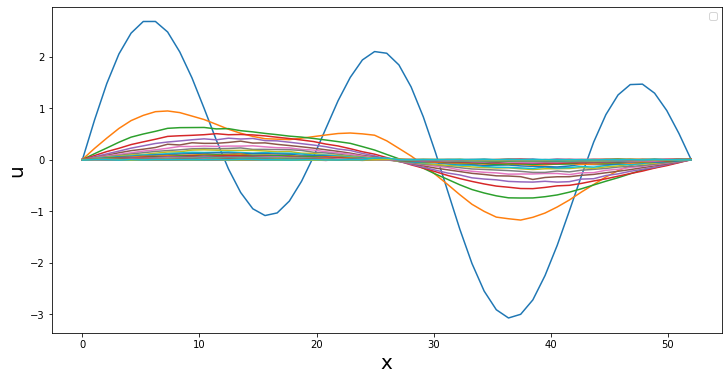

In [22]:
# Plot the predicted data after each layer for the optimal number of layers
plt.figure(figsize=(12, 6))
for i, layer_output in enumerate(K_pred_optimal_layers):
    plt.plot(x_coords, layer_output)

plt.xlabel('x', fontsize=20)
plt.ylabel('u', fontsize=20)
plt.legend()
plt.savefig('PINO_heat_500_4.png')
plt.show()

### sorting out data into correct dimensions

In [288]:
num_sol_heat1 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_1.npy')
exact_sol_heat1 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.npy')

num_sol_heat2 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_2.npy')
exact_sol_heat2 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.npy')

num_sol_heat3 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_3.npy')
exact_sol_heat3 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_3.npy')

num_sol_heat4 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_4.npy')
exact_sol_heat4 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_4.npy')

num_sol_heat5 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_5.npy')
exact_sol_heat5 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_5.npy')


num_sol_heat15 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_1.5.npy')
exact_sol_heat15 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.5.npy')

num_sol_heat25 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_2.5.npy')
exact_sol_heat25 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.5.npy')

num_sol_heat35 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_3.5.npy')
exact_sol_heat35 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_3.5.npy')

num_sol_heat45 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_4.5.npy')
exact_sol_heat45 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_4.5.npy')

num_sol_heat55 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_5.5.npy')
exact_sol_heat55 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_5.5.npy')

num_sol_heat125 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_125.npy')
exact_sol_heat125 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_125.npy')

num_sol_heat225 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_225.npy')
exact_sol_heat225 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_225.npy')

num_sol_heat325 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_325.npy')
exact_sol_heat325 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_325.npy')

num_sol_heat425 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_425.npy')
exact_sol_heat425 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_425.npy')

num_sol_heat525 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_525.npy')
exact_sol_heat525 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_525.npy')

num_sol_heat175 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_175.npy')
exact_sol_heat175 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_175.npy')

num_sol_heat275 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_275.npy')
exact_sol_heat275 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_275.npy')

num_sol_heat375 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_375.npy')
exact_sol_heat375 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_375.npy')

num_sol_heat475 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_475.npy')
exact_sol_heat475 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_475.npy')

num_sol_heat575 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/num_sol_heat_575.npy')
exact_sol_heat575 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_575.npy')

test_case_num = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/test_case_num_sol_heat_7.npy')
test_case_exact = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/test_case_exact_sol_heat_7.npy')


exact_sol_heat1 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.npy')

exact_sol_heat2 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.npy')

exact_sol_heat3 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_3.npy')

exact_sol_heat4 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_4.npy')

exact_sol_heat5 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_5.npy')

#the point 5's

exact_sol_heat15 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.5.npy')

exact_sol_heat25 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.5.npy')

exact_sol_heat35 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_3.5.npy')

exact_sol_heat45 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_4.5.npy')

exact_sol_heat55 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_5.5.npy')

# the point 25's
exact_sol_heat125 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_125.npy')

exact_sol_heat225 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_225.npy')

exact_sol_heat325 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_325.npy')

exact_sol_heat425 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_425.npy')

exact_sol_heat525 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_525.npy')

#the point 75's
exact_sol_heat175 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_175.npy')

exact_sol_heat275 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_275.npy')

exact_sol_heat375 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_375.npy')

exact_sol_heat475 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_475.npy')

exact_sol_heat575 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_575.npy')

test_case_exact = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/test_case_exact_sol_heat_7.npy')


# more for good measure 
exact_sol_heat1_2 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.2.npy')
exact_sol_heat1_3 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.3.npy')
exact_sol_heat1_4 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.4.npy')
exact_sol_heat1_6 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.6.npy')
exact_sol_heat1_7 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.7.npy')
exact_sol_heat1_8 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_1.8.npy')
exact_sol_heat2_1 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.1.npy')
exact_sol_heat2_2 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.2.npy')
exact_sol_heat2_3 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.3.npy')
exact_sol_heat2_4 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.4.npy')
exact_sol_heat2_6 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.6.npy')
exact_sol_heat2_7 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.7.npy')
exact_sol_heat2_8 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_2.8.npy')
exact_sol_heat3_2 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_3.2.npy')
exact_sol_heat3_3 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/heatdata/exact_sol_heat_3.3.npy')



numpy.ndarray

In [292]:
import numpy as np
import os
import pickle as pkl
'''
train_cases = ['num_sol_heat1', 'exact_sol_heat1', 'num_sol_heat2', 'exact_sol_heat2','num_sol_heat3', 'exact_sol_heat3',
               'num_sol_heat4', 'exact_sol_heat4', 'num_sol_heat5', 'num_sol_heat15', 'exact_sol_heat15', 'num_sol_heat25', 
               'exact_sol_heat25', 'num_sol_heat35', 'exact_sol_heat35', 'num_sol_heat45', 'exact_sol_heat45', 'num_sol_heat125', 
               'exact_sol_heat125','num_sol_heat225', 'exact_sol_heat225','num_sol_heat325', 'exact_sol_heat325', 
               'num_sol_heat425', 'exact_sol_heat425','num_sol_heat175', 'exact_sol_heat175','num_sol_heat275', 'exact_sol_heat275',
                'num_sol_heat375', 'exact_sol_heat375', 'num_sol_heat475', 'exact_sol_heat475','test_case_num','test_case_exact']

'''
train_cases = ['exact_sol_heat1', 'exact_sol_heat2', 'exact_sol_heat3', 'exact_sol_heat4', 'exact_sol_heat5',
               'exact_sol_heat15', 'exact_sol_heat25', 'exact_sol_heat35', 'exact_sol_heat45', 'exact_sol_heat125', 
               'exact_sol_heat225', 'exact_sol_heat325', 'exact_sol_heat425', 'exact_sol_heat175', 'exact_sol_heat275', 
               'exact_sol_heat375', 'exact_sol_heat475', 'test_case_num', 'test_case_exact',
               'exact_sol_heat1_2', 'exact_sol_heat1_3', 'exact_sol_heat1_4', 'exact_sol_heat1_6', 'exact_sol_heat1_7', 
               'exact_sol_heat1_8', 'exact_sol_heat2_1', 'exact_sol_heat2_2', 'exact_sol_heat2_3', 'exact_sol_heat2_4', 
               'exact_sol_heat2_6', 'exact_sol_heat2_7', 'exact_sol_heat2_8', 'exact_sol_heat3_2', 'exact_sol_heat3_3']




save_folder = r'C:\Users\alann\Desktop\Dissertation code\pifno2\data\train'

for sc in train_cases:
    print(f'Testing input conditions: {sc}')
    
    TestX = []
    TestY = []

    # Load the data arrays using globals()
    K_data = globals()[sc]
    
    # Create input-output pair, i.e., directly use the data arrays
    K_out = K_data.astype('float32')
    K_inp = K_data.astype('float32')
    TestX.append(K_inp)
    TestY.append(K_out)
        
    # Save data offline    
    data = {'X': TestX, 'Y': TestY}
    
    with open(os.path.join(save_folder, 'train-{}.pkl'.format(sc)), 'wb') as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)


Testing input conditions: exact_sol_heat1
Testing input conditions: exact_sol_heat2
Testing input conditions: exact_sol_heat3
Testing input conditions: exact_sol_heat4
Testing input conditions: exact_sol_heat5
Testing input conditions: exact_sol_heat15
Testing input conditions: exact_sol_heat25
Testing input conditions: exact_sol_heat35
Testing input conditions: exact_sol_heat45
Testing input conditions: exact_sol_heat125
Testing input conditions: exact_sol_heat225
Testing input conditions: exact_sol_heat325
Testing input conditions: exact_sol_heat425
Testing input conditions: exact_sol_heat175
Testing input conditions: exact_sol_heat275
Testing input conditions: exact_sol_heat375
Testing input conditions: exact_sol_heat475
Testing input conditions: test_case_num
Testing input conditions: test_case_exact
Testing input conditions: exact_sol_heat1_2
Testing input conditions: exact_sol_heat1_3
Testing input conditions: exact_sol_heat1_4
Testing input conditions: exact_sol_heat1_6
Testing 